## learning-AI101 : HARTH classification (DL)
### The Human Activity Recognition Trondheim (HARTH)를 CNN 1D 방식의 classification

<br>

- **임규연 (lky473736)**
- 2024.08.04., 2024.08.23. ~ 2024.09.01.에 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/779/harth
- **data abstract** : The Human Activity Recognition Trondheim (HARTH) dataset is a professionally-annotated dataset containing 22 subjects wearing two 3-axial accelerometers for around 2 hours in a free-living setting. The sensors were attached to the right thigh and lower back. The professional recordings and annotations provide a promising benchmark dataset for researchers to develop innovative machine learning approaches for precise HAR in free living.

------



## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 HARTH을 classification한다. **1D-CNN을 통하여 classification한다.**

In [1]:
# 라이브러리 import

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

2024-08-30 00:33:20.620220: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# records 병합

import glob

directory_path = '../../data/harth'

# 모든 CSV 파일의 경로를 가져오기
all_files = glob.glob(directory_path + "/*.csv")

print (all_files)

# 데이터프레임을 담을 빈 리스트 생성
df_list = []

# 모든 파일을 순회하며 데이터프레임에 추가
for filename in all_files :
    df = pd.read_csv(filename)  
    df_list.append(df) 

merged_df = pd.concat(df_list, ignore_index=True) # 병합 (header는 ignore)
df = merged_df

df.head()

['../../data/harth/S016.csv', '../../data/harth/S017.csv', '../../data/harth/S029.csv', '../../data/harth/S015.csv', '../../data/harth/S014.csv', '../../data/harth/S028.csv', '../../data/harth/S010.csv', '../../data/harth/S013.csv', '../../data/harth/S012.csv', '../../data/harth/S006.csv', '../../data/harth/S023.csv', '../../data/harth/S022.csv', '../../data/harth/S008.csv', '../../data/harth/S020.csv', '../../data/harth/S021.csv', '../../data/harth/S009.csv', '../../data/harth/S025.csv', '../../data/harth/S019.csv', '../../data/harth/S018.csv', '../../data/harth/S024.csv', '../../data/harth/S026.csv', '../../data/harth/S027.csv']


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,index,Unnamed: 0
0,2019-01-12 00:00:00.000,-0.982201,-0.031251,0.178300,-0.935149,0.006160,-0.358898,6,NaN,NaN
1,2019-01-12 00:00:00.020,-0.973421,-0.042747,0.190618,-0.934986,0.040489,-0.366376,6,NaN,NaN
2,2019-01-12 00:00:00.040,-0.977409,-0.033531,0.185584,-0.939761,0.028617,-0.370106,6,NaN,NaN
3,2019-01-12 00:00:00.060,-0.974620,-0.034506,0.188868,-0.939667,0.036060,-0.369624,6,NaN,NaN
4,2019-01-12 00:00:00.080,-0.976828,-0.041577,0.186524,-0.946145,0.030512,-0.363411,6,NaN,NaN


In [3]:
# timestamp, index 삭제, unnamed 삭제

try : 
    del df['timestamp']
    del df['index']
except : 
    pass

df.drop(['Unnamed: 0'], axis = 1, inplace = True)
print ("현재 attribute : ", df.columns)

현재 attribute :  Index(['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label'], dtype='object')


In [4]:
# df의 크기 및 info
print("df 크기 : ", df.shape)
df.info()

df 크기 :  (6461328, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6461328 entries, 0 to 6461327
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   back_x   float64
 1   back_y   float64
 2   back_z   float64
 3   thigh_x  float64
 4   thigh_y  float64
 5   thigh_z  float64
 6   label    int64  
dtypes: float64(6), int64(1)
memory usage: 345.1 MB


In [5]:
# target의 class 도수를 확인 (숫자로)

df['label'].value_counts()

label
7      2902703
1      1197155
6       743480
8       428898
13      393963
2       291356
3       254839
4        76217
5        67253
14       55814
130      41785
140       7865
Name: count, dtype: int64

In [6]:
# # iterrows를 사용하여 각 행에 접근

# for index, row in df.iterrows() :
#     compo_label = df.at[index, 'label']
    
#     if compo_label == 13 :
#         df.at[index, 'label'] = 9
        
#     elif compo_label == 14 : 
#         df.at[index, 'label'] = 10
        
#     elif compo_label == 130 : 
#         df.at[index, 'label'] = 11
        
#     elif compo_label == 140 : 
#         df.at[index, 'label'] = 12

df['label'] = df['label'].replace({13: 9, 14: 10, 130: 11, 140: 12})

for_0_based = dict()
for i in range (12) : 
    for_0_based[i+1] = i
    
df['label'] = df['label'].replace(for_0_based)

# label 열의 고유값을 출력
print (df['label'].unique())


[ 5  2  0  6  1  7  4  3  8 10  9 11]


In [7]:
# input과 target으로 split

harth_input = df[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']].to_numpy() 
harth_target = df['label'].to_numpy()

# X_train, y_train, X_test, y_test으로 train set, test set 각각 8:2로 split
# 또한, X_train, y_train, X_val, y_val로 train set, validation set 각각 8:2로 split

X_train, X_test, y_train, y_test = train_test_split(harth_input, harth_target, 
                                                   stratify=harth_target, 
                                                   test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                        test_size=0.2, 
                                                        stratify=y_train)

In [8]:
# StandardScaler을 통한 정규화 진행

ss_transformer = StandardScaler()

ss_transformer.fit(X_train)

X_train_scaled = ss_transformer.transform(X_train)
X_test_scaled = ss_transformer.transform(X_test)
X_val_scaled = ss_transformer.transform(X_val)

In [9]:
# X_train_scaled, X_test_scaled, X_val_scaled 데이터를 3차원 tensor로 전환한다.

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], 
                                           X_train_scaled.shape[1], 
                                           1))

X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], 
                                         X_test_scaled.shape[1], 
                                         1))

X_val_cnn = X_val_scaled.reshape((X_val_scaled.shape[0], 
                                       X_val_scaled.shape[1], 
                                       1))

X_train_cnn.shape, X_test_cnn.shape, X_val_cnn.shape

((4135249, 6, 1), (1292266, 6, 1), (1033813, 6, 1))

-------

### CNN (1D)
- convolution을 통하여 중요한 feature만 도드라지게 하여 학습을 진행한다.
- 아래와 같이 dataset을 구성한다.
    - tensor로 전환하여 Conv1D layer로 convolution을 시행할 수 있을 것 같다. 아래와 같이 전환한다.
        - 배치 크기 : row 갯수 (sample의 수)
        - 길이 : feature 수 (col 수)
        - 채널 : 1 (단일 채널)
    - 전환 후 CNN 1d를 적용하여 main feature extraction 후 pooling을 진행한다.
    - Conv, pooling을 2번 반복 후 dense layer를 두어 regression한다.
        - 중간에 dropout 층을 배치하여 overfitting을 막고 학습에 신중하도록 한다.
- 여기서는 poly set 대신 normal set을 사용하겠다.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 conv1d (Conv1D)             (None, 6, 32)             128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 3, 32)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 32)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 64)             6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                        

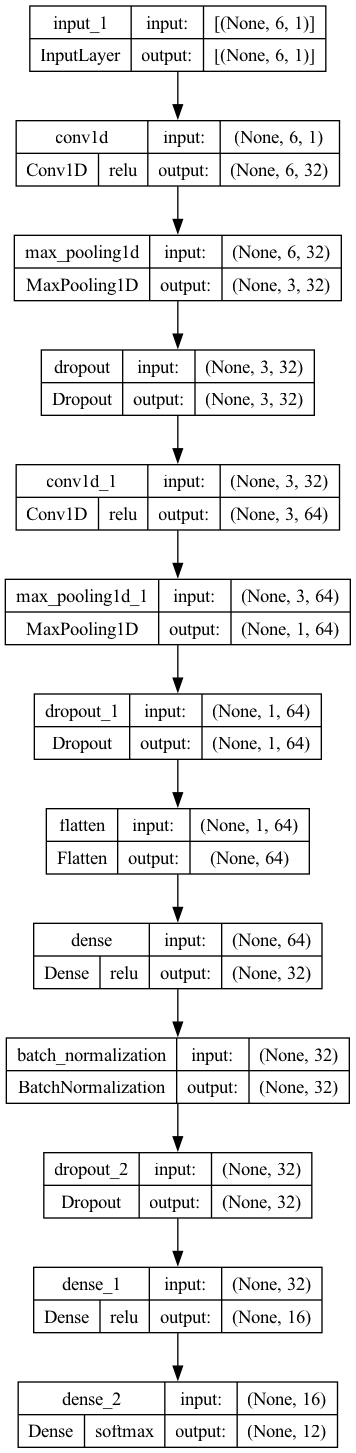

In [10]:
# modelling (functional API 방식)

# 입력 레이어
input_layer = keras.Input(shape=(X_train_scaled.shape[1], 1))

# 첫 번째 Conv1D 레이어 + MaxPooling1D + Dropout
conv_1 = keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
pooling_1 = keras.layers.MaxPooling1D(2)(conv_1)
dropout_1 = keras.layers.Dropout(0.4)(pooling_1)

# 두 번째 Conv1D 레이어 + MaxPooling1D + Dropout
conv_2 = keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(dropout_1)
pooling_2 = keras.layers.MaxPooling1D(2)(conv_2)
dropout_2 = keras.layers.Dropout(0.4)(pooling_2)

# Flatten 레이어
flatten = keras.layers.Flatten()(dropout_2)

# 첫 번째 Dense 레이어 + Batch Normalization + Dropout
dense_1 = keras.layers.Dense(32, activation='relu')(flatten)
batchnorm_1 = keras.layers.BatchNormalization()(dense_1)
dropout_3 = keras.layers.Dropout(0.3)(batchnorm_1)

# 두 번째 Dense 레이어
dense_2 = keras.layers.Dense(16, activation='relu')(dropout_3)

# 출력 레이어
output_layer = keras.layers.Dense(12, activation='softmax')(dense_2)

# model = keras.Model(
#     input_layer,
#     conv_1,
#     pooling_1,
#     conv_2,
#     pooling_2,
#     flatten,
#     dense_1,
#     dropout_1,
#     dense_2,
#     dropout_2,
#     dense_3,
#     output_layer
# )

model = keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [11]:
# compile

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile (optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# fit

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                restore_best_weights=True)

history = model.fit(X_train_cnn, y_train, epochs=100, 
                    validation_data=(X_val_cnn, y_val), batch_size=512, 
                    callbacks=early_stopping_cb, 
                    verbose=True)

Epoch 1/100
8077/8077 [==============================] - 39s 5ms/step - loss: 0.6308 - accuracy: 0.8004 - val_loss: 0.4661 - val_accuracy: 0.8511
Epoch 2/100
8077/8077 [==============================] - 47s 6ms/step - loss: 0.5538 - accuracy: 0.8255 - val_loss: 0.4579 - val_accuracy: 0.8540
Epoch 3/100
8077/8077 [==============================] - 55s 7ms/step - loss: 0.5443 - accuracy: 0.8283 - val_loss: 0.4552 - val_accuracy: 0.8544
Epoch 4/100
8077/8077 [==============================] - 51s 6ms/step - loss: 0.5386 - accuracy: 0.8298 - val_loss: 0.4531 - val_accuracy: 0.8573
Epoch 5/100
8077/8077 [==============================] - 53s 7ms/step - loss: 0.5357 - accuracy: 0.8305 - val_loss: 0.4544 - val_accuracy: 0.8558
Epoch 6/100
8077/8077 [==============================] - 73s 9ms/step - loss: 0.5334 - accuracy: 0.8313 - val_loss: 0.4505 - val_accuracy: 0.8569
Epoch 7/100
8077/8077 [==============================] - 87s 11ms/step - loss: 0.5322 - accuracy: 0.8317 - val_loss: 0.4433 

{'loss': [0.6308242082595825, 0.5537884831428528, 0.5443040728569031, 0.5385960340499878, 0.5357434749603271, 0.5334157347679138, 0.5321922302246094, 0.5302350521087646, 0.5292934775352478, 0.528016209602356], 'accuracy': [0.8003876209259033, 0.8255270719528198, 0.8282971382141113, 0.829789936542511, 0.8305485248565674, 0.8312655687332153, 0.831746518611908, 0.8324236273765564, 0.8327551484107971, 0.8333019614219666], 'val_loss': [0.4660685360431671, 0.45794010162353516, 0.45520031452178955, 0.4531347155570984, 0.4544197916984558, 0.4505296051502228, 0.4433363974094391, 0.45024481415748596, 0.44505366683006287, 0.4459172189235687], 'val_accuracy': [0.8510533571243286, 0.8540480732917786, 0.8544175624847412, 0.8573059439659119, 0.8558172583580017, 0.8569180369377136, 0.8590673804283142, 0.8583592772483826, 0.8607010841369629, 0.8593682050704956]}


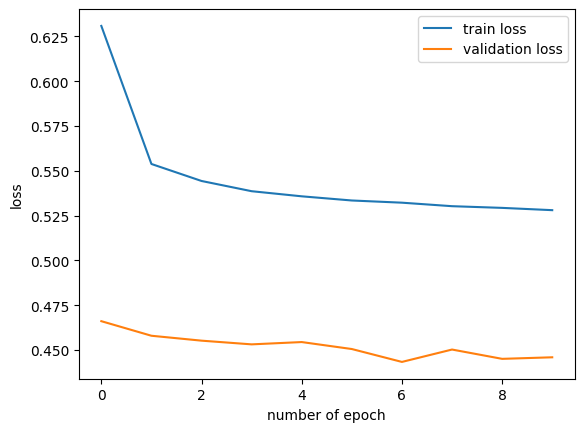

In [13]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

In [14]:
# evaluate

model.evaluate(X_val_cnn, y_val)

32307/32307 [==============================] - 29s 902us/step - loss: 0.4433 - accuracy: 0.8591


[0.44333553314208984, 0.8590673804283142]

In [15]:
# confusion matrix 및 report
# validation dataset과 test dataset을 따로 report 및 matrix drawing

from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model.predict(X_val_cnn)
y_test_pred = model.predict(X_test_cnn)

y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

############

cm_val = confusion_matrix(y_val, y_val_pred_classes)
print ("- validation data confusion matrix -\n")
print (cm_val)

print ('\n --------------- \n')

cm_test = confusion_matrix(y_test, y_test_pred_classes)
print ("- test data confusion matrix -\n")
print (cm_test)

print ('\n --------------- \n')

cr_val = classification_report(y_val, y_val_pred_classes)
print ("- validation data report of classification -\n")
print (cr_val)

print ('\n --------------- \n')

cr_test = classification_report(y_test, y_test_pred_classes)
print ("- test data report of classification -\n")
print (cr_test)

print ('\n --------------- \n')

40384/40384 [==============================] - 27s 666us/step
- validation data confusion matrix -

[[160210   2263      0      0      0  21896    758     88   5970    327
      33      0]
 [ 11786  32926      0      0      0    154    613    569    395    174
       0      0]
 [ 13734     84      0      0      0  24972    348     35   1439    130
      32      0]
 [  8192    277      0      0      0   1243     58     15   2367     41
       2      0]
 [  9108    556      0      0      0    441     22     20    601     13
       0      0]
 [  7093    104      0      0      0 108274   1168     18   2049    238
      13      0]
 [   970     13      0      0      0    210 462254    145    838      3
       0      0]
 [    65     24      0      0      0      3     95  68428      8      1
       0      0]
 [  6234    206      0      0      0   1094    891     44  54291    274
       0      0]
 [  3040    200      0      0      0    370     37     17   3614   1652
       0      0]
 [   268  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

- validation data report of classification -

              precision    recall  f1-score   support

           0       0.73      0.84      0.78    191545
           1       0.90      0.71      0.79     46617
           2       0.00      0.00      0.00     40774
           3       0.00      0.00      0.00     12195
           4       0.00      0.00      0.00     10761
           5       0.68      0.91      0.78    118957
           6       0.99      1.00      0.99    464433
           7       0.99      1.00      0.99     68624
           8       0.70      0.86      0.77     63034
           9       0.56      0.18      0.28      8930
          10       0.50      0.01      0.02      6685
          11       0.00      0.00      0.00      1258

    accuracy                           0.86   1033813
   macro avg       0.50      0.46      0.45   1033813
weighted avg       0.81      0.86      0.83   1033813


 --------------- 



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- test data report of classification -

              precision    recall  f1-score   support

           0       0.73      0.84      0.78    239431
           1       0.90      0.71      0.79     58271
           2       0.00      0.00      0.00     50968
           3       0.00      0.00      0.00     15243
           4       0.00      0.00      0.00     13450
           5       0.68      0.91      0.78    148696
           6       0.99      1.00      0.99    580541
           7       0.99      1.00      0.99     85780
           8       0.70      0.86      0.77     78793
           9       0.56      0.19      0.28     11163
          10       0.47      0.01      0.02      8357
          11       0.00      0.00      0.00      1573

    accuracy                           0.86   1292266
   macro avg       0.50      0.46      0.45   1292266
weighted avg       0.81      0.86      0.83   1292266


 --------------- 



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----

하지만, 위 결과를 잘 생각해보자. **CNN을 진행 시에 split_sequence로 순환형 데이터를 만들지 않고, 단지 df에서 reshape한 형태로만 학습을 진행했다.** 이는 그저 **DNN과 다름이 없을 뿐**이니, split_sequence 함수를 사용하여 데이터를 순환형으로 만든 후에 다시 학습을 진행한다. split_sequence를 아래와 같이 정의하자.

In [16]:
def split_sequence (sequences, n_steps) :
    X, y = [], [] 
    
    for i in range(len(sequences)) :
        end_ix = i + n_steps
        if end_ix > len(sequences)-1 :
            break
            
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1]
        
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [17]:
# sequential data로 변경 (여기서의 타임 스텝은 300으로)

n_steps = 300

X_train_seq, y_train_seq = split_sequence (np.column_stack((X_train_scaled, y_train)), n_steps)
X_test_seq, y_test_seq = split_sequence (np.column_stack((X_test_scaled, y_test)), n_steps)
X_val_seq, y_val_seq = split_sequence (np.column_stack((X_val_scaled, y_val)), n_steps)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 6)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 300, 64)           1216      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 150, 64)           0         
 g1D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 150, 64)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 150, 64)           12352     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 75, 64)            0         
 g1D)                                                      

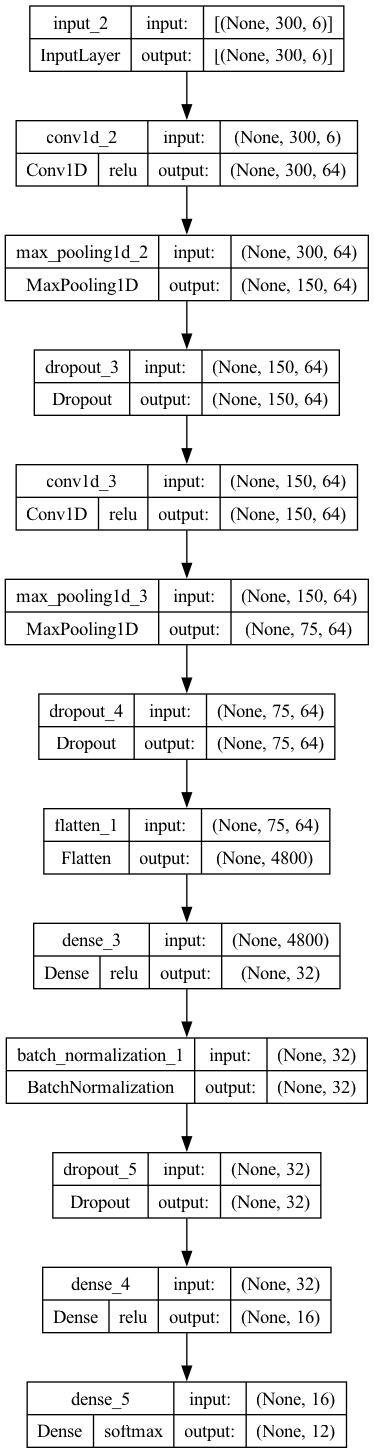

In [18]:
# 다시 modelling

# 입력 레이어
input_layer = keras.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

# 첫 번째 Conv1D 레이어 + MaxPooling1D + Dropout
conv_1 = keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
pooling_1 = keras.layers.MaxPooling1D(2)(conv_1)
dropout_1 = keras.layers.Dropout(0.4)(pooling_1)

# 두 번째 Conv1D 레이어 + MaxPooling1D + Dropout
conv_2 = keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(dropout_1)
pooling_2 = keras.layers.MaxPooling1D(2)(conv_2)
dropout_2 = keras.layers.Dropout(0.4)(pooling_2)

# Flatten 레이어
flatten = keras.layers.Flatten()(dropout_2)

# 첫 번째 Dense 레이어 + Batch Normalization + Dropout
dense_1 = keras.layers.Dense(32, activation='relu')(flatten)
batchnorm_1 = keras.layers.BatchNormalization()(dense_1)
dropout_3 = keras.layers.Dropout(0.3)(batchnorm_1)

# 두 번째 Dense 레이어
dense_2 = keras.layers.Dense(16, activation='relu')(dropout_3)

# 출력 레이어
output_layer = keras.layers.Dense(12, activation='softmax')(dense_2)

model = keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [19]:
# compile

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile (optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                restore_best_weights=True)

history = model.fit(X_train_seq, y_train_seq, epochs=100, 
                    validation_data=(X_val_seq, y_val_seq), batch_size=64, 
                    callbacks=early_stopping_cb, 
                    verbose=True)

In [ ]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

In [ ]:
# evaluate

model.evaluate(X_val_seq, y_val_seq)

In [ ]:
# confusion matrix 및 report
# validation dataset과 test dataset을 따로 report 및 matrix drawing

from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model.predict(X_val_seq)
y_test_pred = model.predict(X_test_seq)

y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

############

cm_val = confusion_matrix(y_val, y_val_pred_classes)
print ("- validation data confusion matrix -\n")
print (cm_val)

print ('\n --------------- \n')

cm_test = confusion_matrix(y_test, y_test_pred_classes)
print ("- test data confusion matrix -\n")
print (cm_test)

print ('\n --------------- \n')

cr_val = classification_report(y_val, y_val_pred_classes)
print ("- validation data report of classification -\n")
print (cr_val)

print ('\n --------------- \n')

cr_test = classification_report(y_test, y_test_pred_classes)
print ("- test data report of classification -\n")
print (cr_test)

print ('\n --------------- \n')

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix - validation set')
plt.xlabel('predict label')
plt.ylabel('true')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix - test set')
plt.xlabel('predict label')
plt.ylabel('true')
plt.show()